<a href="https://colab.research.google.com/github/berilldindar/Pneumonia-Detection-/blob/main/PneumoniaDetection_ALEXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import  Flatten,Dense
from keras.models import Sequential

import glob, os, random

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [ ]:
norm_images, norm_labels = load_normal('/content/drive/MyDrive/FinalOdevDerin/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/train/PNEUMONIA/')

100%|██████████| 3883/3883 [17:45<00:00,  3.64it/s]


In [ ]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [ ]:
np.unique(y_train,return_counts=True)
#OpenCV'nin görüntüyü okuduğu varsayılan dtype 'uint8' olduğundan, bu görüntü üzerinde çalışan her şeyin uyumluluk için 'uint8' türünde olması gerekir.

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2538, 1349, 1345]))

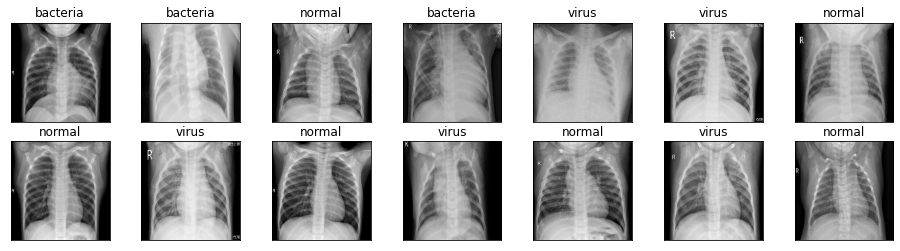

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
norm_images_test, norm_labels_test = load_normal('/content/drive/MyDrive/FinalOdevDerin/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [01:56<00:00,  3.35it/s]


In [ ]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        validation_split=0.1, 
        height_shift_range = 0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

(200, 200, 1)


In [ ]:
from keras.layers import Conv2D,MaxPool2D,ZeroPadding2D

In [ ]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

alexnet=tf.keras.Sequential()
alexnet.add(Conv2D(128,kernel_size=(11,11),strides=(4,4),activation='relu'))

alexnet.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))

alexnet.add(ZeroPadding2D((2,2))) #4tane ekliyor 2,2

alexnet.add(Conv2D(128,kernel_size=(5,5),strides=(1,1),activation='relu'))

alexnet.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))

alexnet.add(ZeroPadding2D((1,1))) 

alexnet.add(Conv2D(256,kernel_size=(3,3),strides=(1,1),activation='relu'))

alexnet.add(ZeroPadding2D((1,1))) 

alexnet.add(Conv2D(256,kernel_size=(3,3),strides=(1,1),activation='relu'))

alexnet.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))

alexnet.add(Flatten())

alexnet.add(Dense(1024,activation='relu'))
alexnet.add(Dense(1024,activation='relu'))
alexnet.add(Dense(3,activation='softmax'))

alexnet.build(X_train.shape) 
alexnet.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (5232, 48, 48, 128)       15616     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (5232, 23, 23, 128)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (5232, 27, 27, 128)       0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (5232, 23, 23, 128)       409728    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (5232, 11, 11, 128)       0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (5232, 13, 13, 128)       0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (5232, 11, 11, 256)       2

In [ ]:
alexnet.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
history = alexnet.fit_generator(train_gen, epochs=20, 
          validation_data=(X_test, y_test_one_hot))



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
164/164 [==============================] - 252s 2s/step - loss: 5.1043 - acc: 0.5136 - val_loss: 1.1630 - val_acc: 0.4872
Epoch 2/20
164/164 [==============================] - 250s 2s/step - loss: 0.9033 - acc: 0.5868 - val_loss: 0.8941 - val_acc: 0.6394
Epoch 3/20
164/164 [==============================] - 250s 2s/step - loss: 0.8103 - acc: 0.6369 - val_loss: 0.7835 - val_acc: 0.6378
Epoch 4/20
164/164 [==============================] - 250s 2s/step - loss: 0.7320 - acc: 0.6825 - val_loss: 0.7494 - val_acc: 0.7003
Epoch 5/20
164/164 [==============================] - 250s 2s/step - loss: 0.7041 - acc: 0.7005 - val_loss: 0.7548 - val_acc: 0.7083
Epoch 6/20
164/164 [==============================] - 250s 2s/step - loss: 0.6492 - acc: 0.7144 - val_loss: 1.0662 - val_acc: 0.5769
Epoch 7/20
164/164 [==============================] - 250s 2s/step - loss: 0.6231 - acc: 0.7313 - val_loss: 0.8028 - val_acc: 0.6587
Epoch 8/20
164/164 [==============================] - 251s 2s/step - 

Displaying accuracy


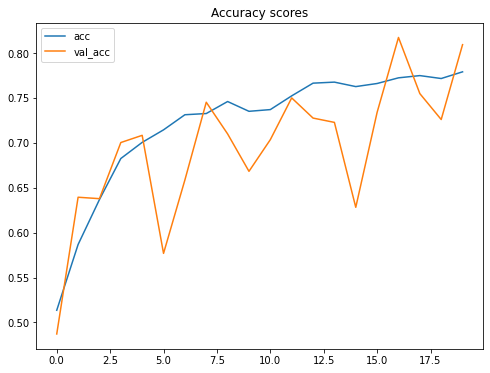

Displaying loss


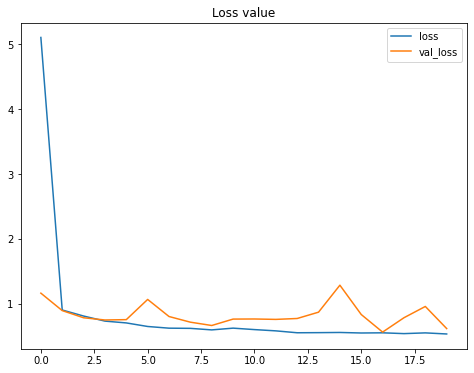

In [ ]:
print('Displaying accuracy')
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

print('Displaying loss')
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
predictions = alexnet.predict(X_test)
print(predictions)

[[0.3506779  0.08860935 0.56071275]
 [0.0863703  0.6791081  0.2345216 ]
 [0.27763575 0.3659408  0.35642347]
 ...
 [0.16519105 0.01725413 0.81755483]
 [0.17126772 0.06467734 0.76405495]
 [0.49128413 0.01793542 0.49078044]]


In [ ]:
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['bacteria', 'normal', 'virus']

Model evaluation
[array(['bacteria', 'normal', 'virus'], dtype='<U8')]


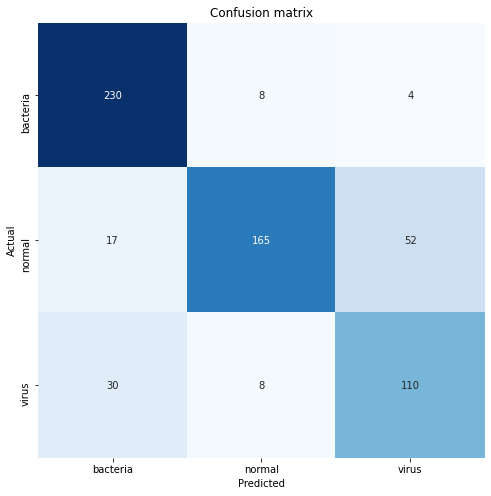

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal',  'bacteria',  'virus']
print(classification_report(y_test,predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.83      0.95      0.89       242
    bacteria       0.91      0.71      0.80       234
       virus       0.66      0.74      0.70       148

    accuracy                           0.81       624
   macro avg       0.80      0.80      0.79       624
weighted avg       0.82      0.81      0.81       624

